# import the necessary packages

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import time
from torch.utils.data import Subset, DataLoader
from typing import List, Tuple
import os
from torch.optim.lr_scheduler import _LRScheduler
import tracemalloc
from enum import Enum
from sklearn.model_selection import StratifiedKFold
import copy
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# MLP

## Parameter settings

In [114]:
# define the enums for hyperparameters
class NumOfHiddenLayer(Enum):
    THREE = 3
    FOUR = 4
    FIVE = 5

class LearningRateScheduler(Enum):
    FIXED = 'None'
    StepLR = 'StepLR'
    CosineAnnealingLR = 'CosineAnnealingLR'
    ReduceLROnPlateau = 'ReduceLROnPlateau'

class ActivationFunction(Enum):
    ReLU = "ReLU"
    LeakyReLU = "LeakyReLU"
    ELU = "ELU"
class Optimizer(Enum):
    SGD = 'SGD'
    Adam = 'Adam'
    RMSprop = 'RMSprop'
class BatchNormalization(Enum):
    True_ = True
    False_ = False
class Regularization(Enum):
    L1 = 'L1'
    L2 = 'L2'
    None_ = None
class Augmentation(Enum):
    True_ = True
    False_ = False
aug_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),         # rotate 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # translate
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x)),  # add gaussian noise
    transforms.Normalize((0.1307,), (0.3081,))
])  
# define the hyperparameters
num_of_hidden_layer = NumOfHiddenLayer.THREE
# hidden_sizes = [32, 32, 32]
# hidden_sizes = [64, 64, 64]
hidden_sizes = [128, 128, 128]
learning_rate_scheduler = LearningRateScheduler.StepLR
activation_function = ActivationFunction.ELU
optimizer = Optimizer.SGD
batch_normalization = BatchNormalization.True_
regularization = Regularization.L1
llambda = 1e-5
dropout = [0.25, 0.25, 0.0]
batch_size = 128
num_epochs = 200
lr = 0.1
augmentation = Augmentation.True_


## download EMNIST dataset and normalize the data

In [107]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # EMNIST normalized
])

train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
print(train_dataset)
print(test_dataset)


Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset EMNIST
    Number of datapoints: 18800
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## plot the data

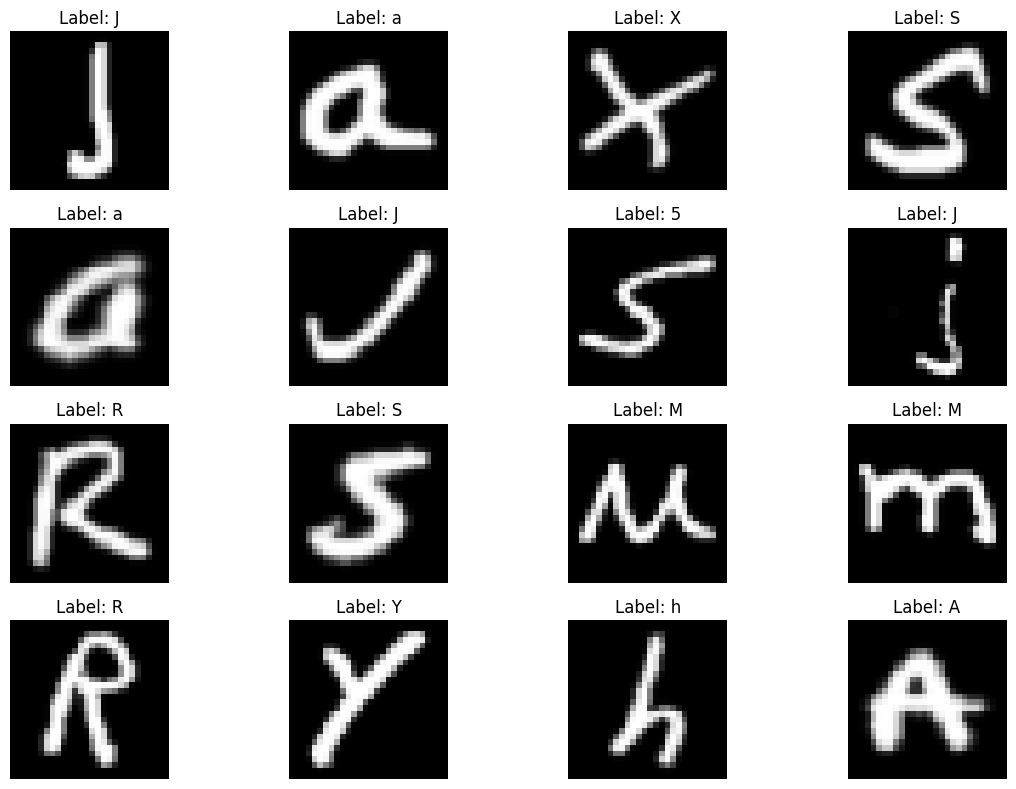

In [108]:
def plot_images(dataset, num_samples=16, cols=4):
    """plot a portion of the sample in the dataset"""
    # samples are selected at random
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    images = [dataset[i][0].squeeze().numpy() for i in indices]  # remove the channel dimension
    labels = [dataset.classes[dataset[i][1]] for i in indices]   # get the tag name

    # set up the canvas
    rows = num_samples // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 2 * rows))
    axes = axes.flatten()

    # draw an image
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.T, cmap='gray')  # note emnist images need to be transposed
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images(train_dataset)

## Define the MLP model

In [109]:
class MLP(nn.Module):
    def __init__(
        self, input_size: int = 28*28, 
        hidden_sizes: List[int] = [128, 128, 128], 
        num_classes: int = 47, 
        activation_fn: nn.Module = nn.ReLU, 
        batch_normalization: bool = True, 
        dropout: List[float] = None, 
    ) -> None:
        super(MLP, self).__init__()
        self.net = nn.Sequential()
        all_layes_sizes = [input_size] + hidden_sizes + [num_classes]
        for i in range(len(all_layes_sizes)-2):
            self.net.add_module(
                f"fc{i}", 
                nn.Linear(all_layes_sizes[i], all_layes_sizes[i+1])
            )
            if batch_normalization:
                self.net.add_module(f"bn{i}", nn.BatchNorm1d(all_layes_sizes[i+1]))
            self.net.add_module(f"activation{i}", activation_fn())
            if dropout is not None and dropout[i] > 1e-4:
                self.net.add_module(f"dropout{i}", nn.Dropout(dropout[i]))
        self.net.add_module("output", nn.Linear(all_layes_sizes[-2], all_layes_sizes[-1])) # output layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1) 
        return self.net(x)

## define the function to train model

In [110]:
def trainMLP(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: Optimizer, scheduler: _LRScheduler, criterion: nn.Module, num_epochs: int, device: torch.device, model_path: str = 'best_model.pth') -> Tuple[List[float], List[float], List[float], List[float], List[float], List[float], List[float], List[float]]:
    model.to(device)
    best_val_loss = float('inf')
    best_val_acc = 0
    best_train_loss = float('inf')
    best_train_acc = 0
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    num_of_no_improvement = 0
    for epoch in range(1, num_epochs + 1):
        train_loss = 0
        correct = 0
        total = 0
        model.train()
        
        epoch_start = time.time()

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # add regularization
            if regularization == Regularization.L1:
                l1_lambda = 1e-5
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
            elif regularization == Regularization.L2:
                l2_lambda = 1e-4
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2_lambda * l2_norm
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        val_loss = 0
        correct = 0
        total = 0
        model.eval()
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if learning_rate_scheduler == LearningRateScheduler.StepLR:
            scheduler.step()
        elif learning_rate_scheduler == LearningRateScheduler.ReduceLROnPlateau:
            scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_train_loss = train_loss
            best_train_acc = train_acc
            torch.save(model.state_dict(), model_path)
            num_of_no_improvement = 0
        else:
            num_of_no_improvement += 1
            if num_of_no_improvement >= 10:
                print(f"Early stopping at epoch {epoch}")
                break
        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start

        if torch.cuda.is_available():
            peak_mem = torch.cuda.max_memory_allocated(device) / 1024 / 1024  # MB
            torch.cuda.reset_peak_memory_stats(device)
        print(f"Epoch {epoch}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_duration:.2f}s, "
              f"Peak Memory: {peak_mem:.2f}MB" if torch.cuda.is_available() else "")
    return best_val_loss, best_val_acc, best_train_loss, best_train_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list

## start training the model

In [ ]:

result_file_path = './result.json'

k = 5
targets = train_dataset.targets.numpy()
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
print("setup:\n"
      f"num_of_hidden_layer: {num_of_hidden_layer.value}, \n"
      f"hidden_sizes: {hidden_sizes}, \n"
      f"learning_rate: {lr}, \n"
      f"learning_rate_scheduler: {learning_rate_scheduler.value}, \n"
      f"optimizer: {optimizer.value}, \n"
      f"activation_function: {activation_function.value}, \n"
      f"batch_normalization: {batch_normalization.value}, \n"
      f"regularization: {regularization.value}, \n"
      f"llamada: {llambda}, \n"
      f"dropout: {dropout}, \n"
      f"augmentation: {augmentation.value}, \n"
      f"num_of_epochs: {num_epochs}, \n"
      f"batch_size: {batch_size}, \n"
      f"num_of_folds: {skf.n_splits}, \n"
      f"augmentation: {augmentation.value}, \n"
      f"train_dataset_size: {len(train_dataset)}, \n"
      f"test_dataset_size: {len(test_dataset)}")
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\nFold {fold+1}')
    model_path = f'./models/best_model_fold_{fold+1}-{k}_num-of-hidden-layer_{num_of_hidden_layer.value}_hidden-sizes_{hidden_sizes}_lr_{lr}_scheduler_{learning_rate_scheduler.value}_optimizer_{optimizer.value}_activation_function_{activation_function.value}_batch_normalization_{batch_normalization.value}_regularization_{regularization.value}_llambda_{llambda}_dropout_{dropout}.pth'
    if augmentation == Augmentation.True_:
        model_path = model_path.replace('.pth', '_aug.pth')
    if os.path.exists(model_path):
        print(f"Model already exists at {model_path}, skipping training.")
        # break
        # continue
    # create the data loaders
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    train_subset.dataset = copy.deepcopy(train_dataset)
    val_subset.dataset = copy.deepcopy(train_dataset)
    if augmentation == Augmentation.True_:
        train_subset.dataset.transform = aug_transform

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    model = MLP(
        input_size=28*28, 
        hidden_sizes=hidden_sizes, 
        num_classes=47, 
        activation_fn=getattr(nn, activation_function.value),
        batch_normalization=batch_normalization.value, 
        dropout=dropout,
    )
    # optimizer_copy = getattr(optim, optimizer.value)(model.parameters(), lr=lr)
    if optimizer == Optimizer.SGD:
        optimizer_copy = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer == Optimizer.Adam:
        optimizer_copy = optim.Adam(model.parameters(), lr=lr)
    elif optimizer == Optimizer.RMSprop:
        optimizer_copy = optim.RMSprop(model.parameters(), lr=lr, alpha=0.9, momentum=0.9)
    if learning_rate_scheduler == LearningRateScheduler.StepLR:
        scheduler = optim.lr_scheduler.StepLR(optimizer_copy, step_size=10, gamma=0.5)
    elif learning_rate_scheduler == LearningRateScheduler.ReduceLROnPlateau:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_copy, mode='min', factor=0.1, patience=5, verbose=True)
    else:
        scheduler = None
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    tracemalloc.start()

    best_val_loss, best_val_acc, best_train_loss, best_train_acc, train_loss_list, val_loss_list, train_acc_list, val_acc_list = trainMLP(
        model, 
        train_loader, 
        val_loader, 
        optimizer_copy, 
        scheduler, 
        criterion, 
        num_epochs=num_epochs, 
        device=device, 
        model_path=model_path
    )
    
    end_time = time.time()
    train_duration = end_time - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f"Training time: {train_duration:.2f} seconds")
    print(f"Peak memory usage: {peak / 1024 / 1024:.2f} MB")    

    new_result = {
        "type": "MLP",
        "num_of_hidden_layer": num_of_hidden_layer.value,
        "hidden_sizes": hidden_sizes,
        "learning_rate": lr,
        "learning_rate_scheduler": learning_rate_scheduler.value,
        "optimizer": optimizer.value,
        "activation_function": activation_function.value,
        "batch_normalization": batch_normalization.value,
        "regularization": regularization.value,
        "llambda": llambda,
        "dropout": dropout,
        "augmentation": augmentation.value,
        "num_of_epochs": num_epochs,
        "batch_size": batch_size,
        "num_of_folds": skf.n_splits,
        "train_dataset_size": len(train_dataset),
        "test_dataset_size": len(test_dataset),
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc,
        "best_train_loss": best_train_loss,
        "best_train_acc": best_train_acc,
        "train_loss_list": train_loss_list,
        "val_loss_list": val_loss_list,
        "train_acc_list": train_acc_list,
        "val_acc_list": val_acc_list,
        "model_path": model_path,
        "fold": fold + 1,
        "num_of_folds": k,
    }
    if os.path.exists(result_file_path):
        with open(result_file_path, "r") as result_file:
            data = json.load(result_file)
    else:
        data = []
    data.append(new_result)
    with open(result_file_path, "w") as result_file:
        json.dump(data, result_file, indent=4)
    print(f"Results saved to {result_file_path}")
    # break

setup:
num_of_hidden_layer: 3, 
hidden_sizes: [128, 128, 128], 
learning_rate: 0.1, 
learning_rate_scheduler: StepLR, 
optimizer: SGD, 
activation_function: ELU, 
batch_normalization: True, 
regularization: L1, 
llamada: 1e-05, 
dropout: [0.25, 0.25, 0.0], 
augmentation: True, 
num_of_epochs: 200, 
batch_size: 128, 
num_of_folds: 5, 
augmentation: True, 
train_dataset_size: 112800, 
test_dataset_size: 18800

Fold 1
Model already exists at ./models/best_model_fold_1-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.25, 0.25, 0.0]_aug.pth, skipping training.
Epoch 1/200, Train Loss: 2.0148, Train Acc: 0.4345, Val Loss: 0.9182, Val Acc: 0.7142, Time: 57.32s, Peak Memory: 26.98MB
Epoch 2/200, Train Loss: 1.5101, Train Acc: 0.5664, Val Loss: 0.7449, Val Acc: 0.7671, Time: 56.98s, Peak Memory: 26.98MB
Epoch 3/200, Train Loss: 1.3724, Train Acc: 0.6062, Val Loss

## eval the model and plot the results

### eval the model on test set

In [ ]:
# define the hyperparameters
num_of_hidden_layer_test = NumOfHiddenLayer.THREE
# hidden_sizes_test = [32, 32, 32]
# hidden_sizes_test = [64, 64, 64]
hidden_sizes_test = [128, 128, 128]
learning_rate_scheduler_test = LearningRateScheduler.StepLR
activation_function_test = ActivationFunction.ELU
optimizer_test = Optimizer.SGD
batch_normalization_test = BatchNormalization.True_
regularization_test = Regularization.L1
llambda_test = 1e-5
dropout_test = [0.0, 0.0, 0.0]
batch_size_test = 128
num_epochs_test = 200
lr_test = 0.1
augmentation_test = Augmentation.True_

accuracy_list = []
for i in range(1, k+1):
    model_path_test = f'./models/best_model_fold_{i}-{k}_num-of-hidden-layer_{num_of_hidden_layer_test.value}_hidden-sizes_{hidden_sizes_test}_lr_{lr_test}_scheduler_{learning_rate_scheduler_test.value}_optimizer_{optimizer_test.value}_activation_function_{activation_function_test.value}_batch_normalization_{batch_normalization_test.value}_regularization_{regularization_test.value}_llambda_{llambda_test}_dropout_{dropout_test}.pth'
    if augmentation_test == Augmentation.True_:
        model_path_test = model_path_test.replace('.pth', '_aug.pth')
    print(f"Loading model from {model_path_test}")
    test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
    model_test = MLP(
        input_size=28*28, 
        hidden_sizes=hidden_sizes_test, 
        num_classes=47, 
        activation_fn=getattr(nn, activation_function_test.value),
        batch_normalization=batch_normalization_test.value, 
        dropout=dropout_test,
    )
    model_test.load_state_dict(torch.load(model_path_test))
    model_test.to(device)
    model_test.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_test(data)
            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    # calculate the precision, recall, f1-score, accuracy, and confusion matrix
    prcision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    # cm = confusion_matrix(all_labels, all_preds)
    # print(f"Precision: {prcision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1-score: {f1:.4f}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"Confusion Matrix:\n{cm}")
    # # plot the confusion matrix
    # plt.figure(figsize=(10, 10))
    # ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes).plot(cmap=plt.cm.Blues)
    # plt.title("Confusion Matrix")
    # plt.show()
    accuracy_list.append(accuracy)
    print(f"Fold {i} - Accuracy: {accuracy:.4f}")
print(f"Average accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")

Loading model from ./models/best_model_fold_1-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.0, 0.0, 0.0].pth
Fold 1 - Accuracy: 0.8548
Loading model from ./models/best_model_fold_2-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.0, 0.0, 0.0].pth
Fold 2 - Accuracy: 0.8548
Loading model from ./models/best_model_fold_3-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_True_regularization_L1_llambda_1e-05_dropout_[0.0, 0.0, 0.0].pth
Fold 3 - Accuracy: 0.8505
Loading model from ./models/best_model_fold_4-5_num-of-hidden-layer_3_hidden-sizes_[128, 128, 128]_lr_0.1_scheduler_StepLR_optimizer_SGD_activation_function_ELU_batch_normalization_Tru

### get the average accuracy and loss for 5-fold cross-validation

In [ ]:
import pandas as pd
with open('./result.json', "r") as result_file:
    data = json.load(result_file)
# print(str(hidden_sizes_test))
# print(type(df['hidden_sizes'][0]))
df = pd.DataFrame(data)
print(len(df))
print(regularization_test.value)
df['regularization'] = df['regularization'].apply(lambda x: x if x is not None else 'None')
df = df[(df['num_of_hidden_layer'] == num_of_hidden_layer_test.value) &
        (df['hidden_sizes'].apply(lambda x: x == hidden_sizes_test)) &
        (df['learning_rate'] == lr_test) &
        (df['learning_rate_scheduler'] == learning_rate_scheduler_test.value) &
        (df['optimizer'] == optimizer_test.value) &
        (df['activation_function'] == activation_function_test.value) &
        (df['batch_normalization'] == batch_normalization_test.value) &
        (df['regularization'] == str(regularization_test.value)) &
        (df['llambda'] == llambda_test) &
        (df['dropout'].apply(lambda x: x == dropout_test)) &
        (df['num_of_epochs'] == num_epochs_test) &
        (df['batch_size'] == batch_size_test)]
if augmentation_test == Augmentation.True_:
    df = df[df['augmentation'] == True]
display(df)
print(f'best_val_acc: {df["best_val_acc"].mean():.4f} ± {df["best_val_acc"].std():.4f}')
print(f'best_train_acc: {df["best_train_acc"].mean():.4f} ± {df["best_train_acc"].std():.4f}')
print(f'best_val_loss: {df["best_val_loss"].mean():.4f} ± {df["best_val_loss"].std():.4f}')
print(f'best_train_loss: {df["best_train_loss"].mean():.4f} ± {df["best_train_loss"].std():.4f}')


75
L1


,type,num_of_hidden_layer,hidden_sizes,learning_rate,learning_rate_scheduler,optimizer,activation_function,batch_normalization,regularization,llambda,...,best_val_loss,best_val_acc,best_train_loss,best_train_acc,train_loss_list,val_loss_list,train_acc_list,val_acc_list,model_path,fold
70,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.425995,0.858732,0.435505,0.880740,"[1.0514524084456423, 0.7243618022888265, 0.644...","[0.7067492602987492, 0.5978496709613935, 0.553...","[0.6959109042553191, 0.7877327127659575, 0.812...","[0.7665780141843972, 0.8055407801418439, 0.818...",./models/best_model_fold_1-5_num-of-hidden-lay...,1
71,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.440129,0.851729,0.432622,0.883234,"[1.0543164833217649, 0.7173462152903807, 0.639...","[0.727763547204065, 0.6220474506946321, 0.5540...","[0.6983710106382979, 0.7906914893617021, 0.815...","[0.7598404255319149, 0.793395390070922, 0.8178...",./models/best_model_fold_2-5_num-of-hidden-lay...,2
72,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.432746,0.853945,0.418136,0.884896,"[1.0521992535455853, 0.7191353792417134, 0.639...","[0.7469477131011638, 0.6005892899864954, 0.536...","[0.695844414893617, 0.7893506205673759, 0.8159...","[0.7588652482269503, 0.7944148936170212, 0.823...",./models/best_model_fold_3-5_num-of-hidden-lay...,3
73,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.416130,0.856959,0.433566,0.881738,"[1.053413792366677, 0.7183074340329948, 0.6442...","[0.7002566995350181, 0.5842840658857468, 0.524...","[0.6973404255319149, 0.7907801418439716, 0.813...","[0.7752659574468085, 0.8061170212765958, 0.821...",./models/best_model_fold_4-5_num-of-hidden-lay...,4
74,MLP,3,"[128, 128, 128]",0.1,StepLR,SGD,ELU,True,L1,0.00001,...,0.417003,0.859486,0.433688,0.882824,"[1.0582838099053566, 0.7216449434030141, 0.644...","[0.6996115853600469, 0.6007132342521181, 0.545...","[0.6967863475177305, 0.7901374113475177, 0.813...","[0.7782801418439717, 0.8011081560283688, 0.821...",./models/best_model_fold_5-5_num-of-hidden-lay...,5


best_val_acc: 0.8562 ± 0.0033
best_train_acc: 0.8827 ± 0.0016
best_val_loss: 0.4264 ± 0.0103
best_train_loss: 0.4307 ± 0.0071
